In [1]:
import numpy as np
from scipy.integrate import ode
import scipy.io as sio
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

In [2]:
def create_cmap(color1, color2, color3):
    colors = [color1, color2, color3]
    cmap_name = 'list'
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
    return cmap
 
def lorenz(t, state, par): 
    x, y, z = state
    σ, ρ, β = par
    ẋ = σ * (y - x)
    ẏ = (x * (ρ - z)) - y
    ż = (x * y) - (β * z)
    dx = np.array((ẋ, ẏ, ż))
    return dx

def rossler(t, state, par):
    x, y, z = state
    a, b, c = par 
    ẋ = -y - z
    ẏ = x + (a * y)
    ż = b + z * (x - c)
    dx = np.array((ẋ, ẏ, ż))
    return dx

def get_lorenz_data(tspan):
    σ, ρ, β = 10, 28, 8 / 3 # chaotic parameters
    initial = np.array([-8, 8, 27]) # initial condition
    data = np.empty((3, len(tspan)))
    data[:, 0] = initial
    r = ode(lorenz).set_integrator('dopri5')
    r.set_initial_value(initial, tspan[0])
    r.set_f_params((σ, ρ, β))
    for i, t in enumerate(tspan):
        if i == 0:
            continue
        r.integrate(t)
        data[:, i] = r.y
    return data

def get_rossler_data(tspan):
    a, b, c = 0.1, 0.1, 14 # chaotic parameters
    initial = np.array([1, 1, 1]) # initial condition
    data = np.empty((3, len(tspan)))
    data[:, 0] = initial
    r = ode(rossler).set_integrator('dopri5')
    r.set_initial_value(initial, tspan[0])
    r.set_f_params((a, b, c))
    for i, t in enumerate(tspan):
        if i == 0:
            continue
        r.integrate(t)
        data[:, i] = r.y
    return data
    
def get_pendulum_data(samples):
    data = np.loadtxt('doublependulum.dat')
    xdata = np.sin(data[:, 1]) # x(t) = sin(Θ1(t))
    return xdata[:samples]

def build_hankel(data, rows, cols):
    X = np.empty((rows, cols))
    for k in range(rows):
        X[k, :] = data[k:cols + k]
    return X 

def HAVOK(X, dt, r, norm, center=False, return_uv=False):
    if (center): 
        m = X.shape[0]
        X̄ = X - X[m//2,:]
        U, Σ, Vh = np.linalg.svd(X̄,full_matrices=False)
    else:
        U, Σ, Vh = np.linalg.svd(X,full_matrices=False)
    V = Vh.T
    polys = true_polys(X.shape[0], dt, r, center)
    for _i in range(r):
        if (np.dot(U[:,_i], polys[:,_i]) < 0):
            U[:,_i] *= -1
            V[:,_i] *= -1
    V1 = V[:-1,:r]
    V2 = V[1:,:r]
    A = (V2.T @ np.linalg.pinv(V1.T) - np.eye(r)) / (norm * dt)
    if (return_uv): 
        return A, U, V
    return A

def sHAVOK(X, dt, r, norm):
    X1 = X[:,:-1]
    X2 = X[:,1:]
    U1,_,Vh1 = np.linalg.svd(X1,full_matrices=False)
    U2,_,Vh2 = np.linalg.svd(X2,full_matrices=False)
    V1 = Vh1.T
    V2 = Vh2.T
    polys = true_polys(X.shape[0], dt, r, center=False)
    for _i in range(r):
        if (np.dot(U1[:,_i], polys[:,_i]) < 0):
            V1[:,_i] *= -1
        if (np.dot(U2[:,_i], polys[:,_i]) < 0):
            V2[:,_i] *= -1
    A = ((V2.T @ V1)[:r,:r] - np.eye(r)) / (norm * dt)
    return A

def true_polys(rows, dt, r, center): 
    m = rows // 2
    Ut = np.linspace(-m*dt, m*dt, rows)
    poly_stack = []
    for j in range(r):
        if (center):
            poly_stack.append(Ut ** (j + 1))
        else: 
            poly_stack.append(Ut ** j)
    poly_stack = np.vstack(poly_stack).T
    Q = np.empty((rows, r)) # Perform Gram-Schmidt
    for j in range(r): 
        v = poly_stack[:, j]
        for k in range(j - 1): 
            r_jk = Q[:, k].T @ poly_stack[:, j]
            v -= (r_jk * Q[:, k])
        r_jj = np.linalg.norm(v)
        Q[:, j] = v / r_jj
    return Q

# Define colormap 
cmap = create_cmap('tab:blue', 'white', 'tab:orange')

# Lorenz

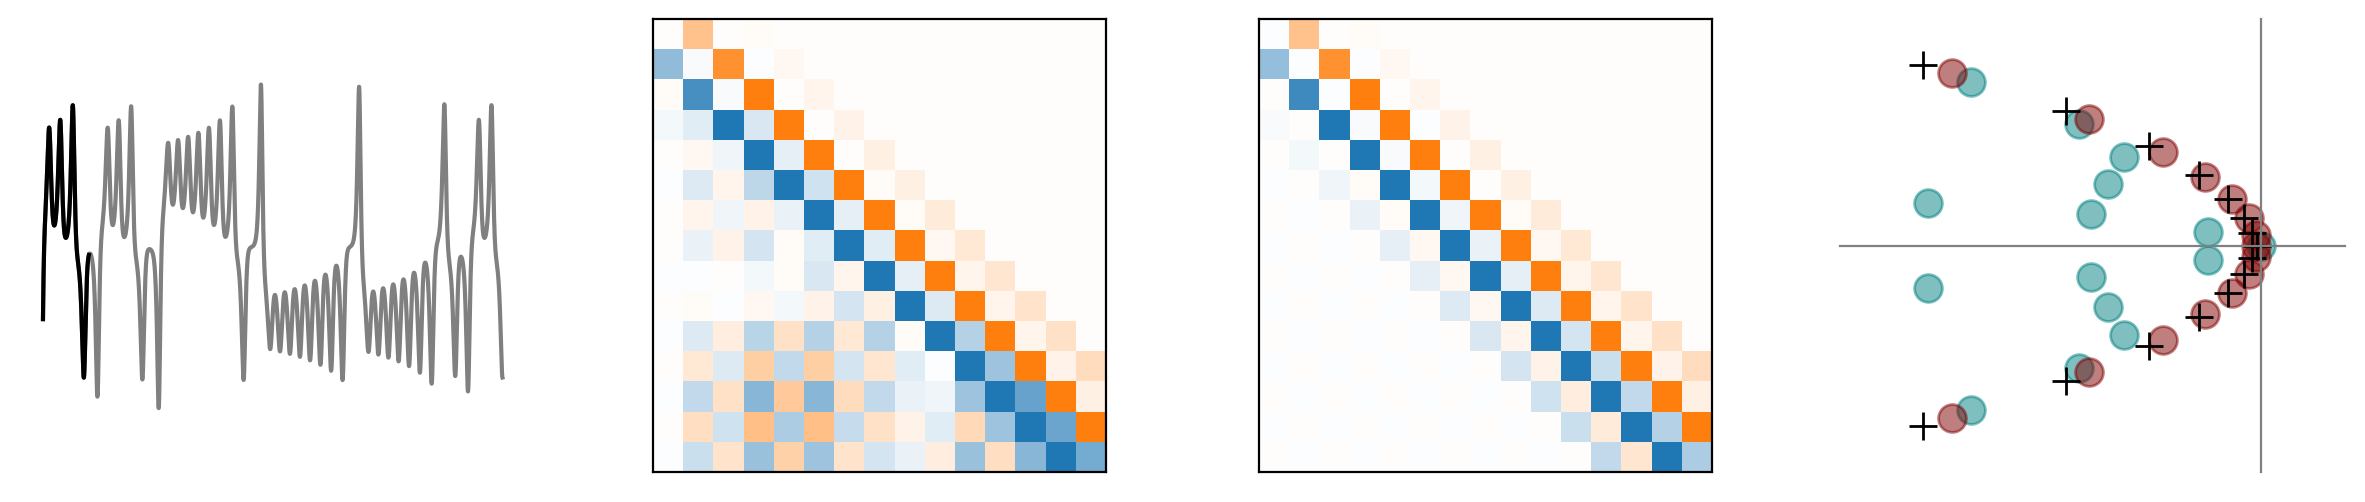

In [3]:
# Define parameters 
r = 15
rows = 201
dt = 0.001 

short = dict()
longplot = dict()
full = dict()
short['n'] = 3000
longplot['n'] = int(30000)
full['n'] = int(300000)

ωs_havok = []
ωs_shavok = []

for elem in (short, longplot, full):
    elem['tspan'] = np.arange(elem['n']) * dt
    elem['xdata'] = get_lorenz_data(elem['tspan'])[0,:]
    elem['H'] = build_hankel(elem['xdata'],rows,elem['xdata'].size-rows+1)
    elem['A1'] = HAVOK(elem['H'],dt,r,1)
    elem['A2'] = sHAVOK(elem['H'],dt,r,1)
    elem['ω1'] = np.linalg.eig(elem['A1'])[0]
    elem['ω2'] = np.linalg.eig(elem['A2'])[0]
    
# Plot results 
plt.figure(figsize=(15,3),dpi=200)

# Time series 
plt.subplot(1,4,1)
plt.plot(longplot['xdata'],color='gray')
plt.plot(short['xdata'],color='black')
plt.ylim(np.min(longplot['xdata']*1.4),np.max(longplot['xdata']*1.4))
plt.axis('off')
plt.xticks([])
plt.yticks([])

# HAVOK dynamics matrix 
plt.subplot(1,4,2)
plt.imshow(short['A1'],cmap=cmap,vmin=-10,vmax=10)
plt.xticks([])
plt.yticks([])
plt.grid('on',color='k')

# sHAVOK dynamics matrix 
plt.subplot(1,4,3)
plt.imshow(short['A2'],cmap=cmap,vmin=-10,vmax=10)
plt.xticks([])
plt.yticks([])

# Eigenvalues 
ax = plt.subplot(1,4,4)
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.xticks([])
plt.yticks([])
plt.plot(short['ω1'].real,short['ω1'].imag,'o',color='teal',markersize=10,label='HAVOK',alpha=0.5)
plt.plot(short['ω2'].real,short['ω2'].imag,'o',color='maroon',markersize=10,label='sHAVOK',alpha=0.5)
plt.plot(full['ω1'].real,full['ω1'].imag,'+',color='k',markersize=10,label='true')
plt.xlim([-6,1.2])
plt.ylim([-120,120])
plt.savefig('pdf_files/fig8a.pdf')

# Rossler

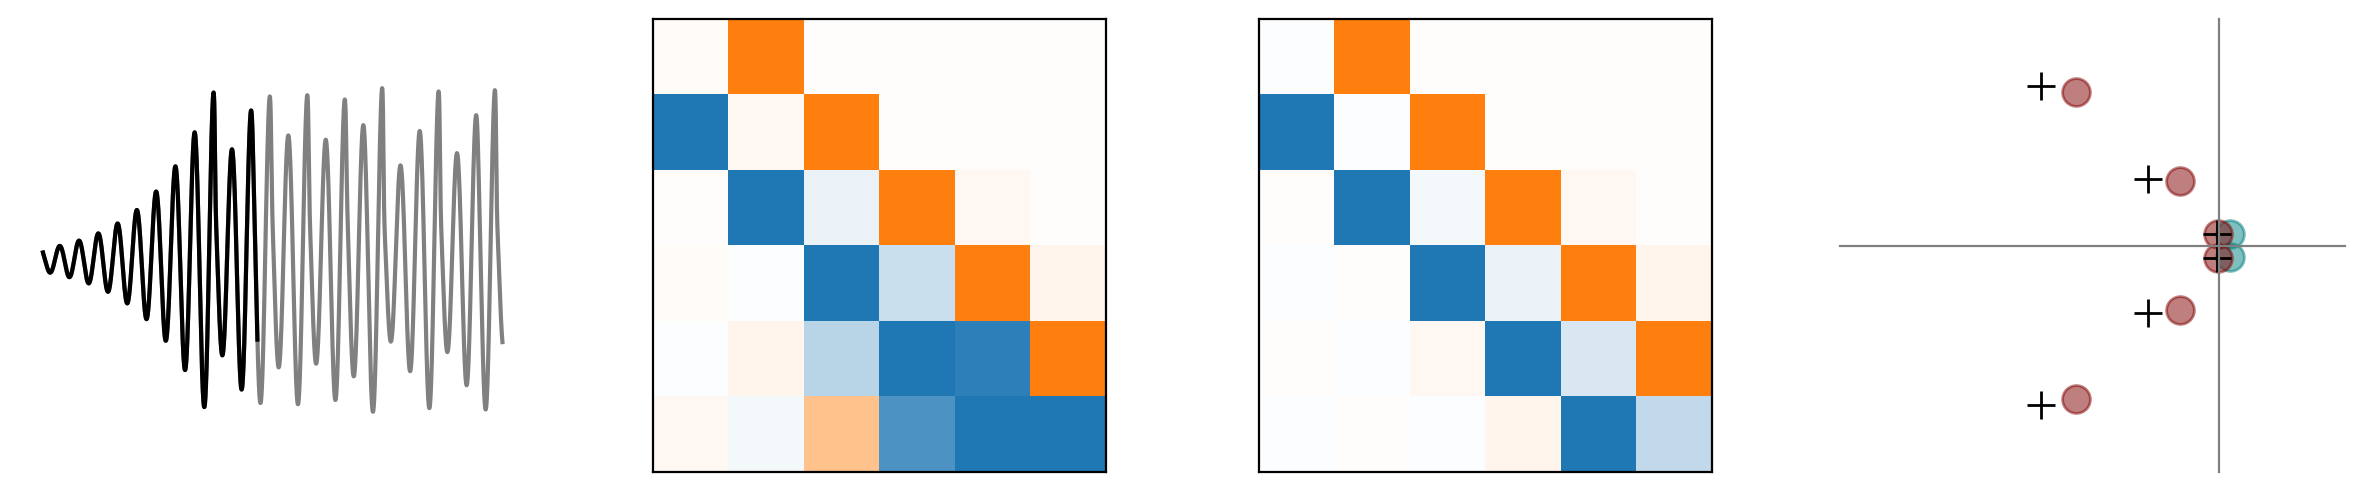

In [4]:
# Define parameters 
r = 6
rows = 11
dt = 0.001 

short = dict()
longplot = dict()
full = dict()
short['n'] = 70000
longplot['n'] = 150000
full['n'] = int(10**5.5)

ωs_havok = []
ωs_shavok = []

for elem in (short, longplot, full):
    elem['tspan'] = np.arange(elem['n']) * dt
    elem['xdata'] = get_rossler_data(elem['tspan'])[0,:]
    elem['H'] = build_hankel(elem['xdata'],rows,elem['xdata'].size-rows+1)
    elem['A1'] = HAVOK(elem['H'],dt,r,1)
    elem['A2'] = sHAVOK(elem['H'],dt,r,1)
    elem['ω1'] = np.linalg.eig(elem['A1'])[0]
    elem['ω2'] = np.linalg.eig(elem['A2'])[0]
    
# Plot results 
plt.figure(figsize=(15,3),dpi=200)

# Time series 
plt.subplot(1,4,1)
plt.plot(longplot['xdata'],color='gray')
plt.plot(short['xdata'],color='black')
plt.ylim(np.min(longplot['xdata']*1.4),np.max(longplot['xdata']*1.4))
plt.axis('off')
plt.xticks([])
plt.yticks([])

# HAVOK dynamics matrix 
plt.subplot(1,4,2)
plt.imshow(short['A1'],cmap=cmap,vmin=-0.5,vmax=0.5)
plt.xticks([])
plt.yticks([])
plt.grid('on',color='k')

# sHAVOK dynamics matrix 
plt.subplot(1,4,3)
plt.imshow(short['A2'],cmap=cmap,vmin=-0.5,vmax=0.5)
plt.xticks([])
plt.yticks([])

# Eigenvalues 
ax = plt.subplot(1,4,4)
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.xticks([])
plt.yticks([])
plt.plot(short['ω1'].real,short['ω1'].imag,'o',color='teal',markersize=10,label='HAVOK',alpha=0.5)
plt.plot(short['ω2'].real,short['ω2'].imag,'o',color='maroon',markersize=10,label='sHAVOK',alpha=0.5)
plt.plot(full['ω1'].real,full['ω1'].imag,'+',color='k',markersize=10,label='true')
plt.xlim([-0.3,0.1])
plt.ylim([-20,20])
plt.savefig('pdf_files/fig8b.pdf')

# Double Pendulum

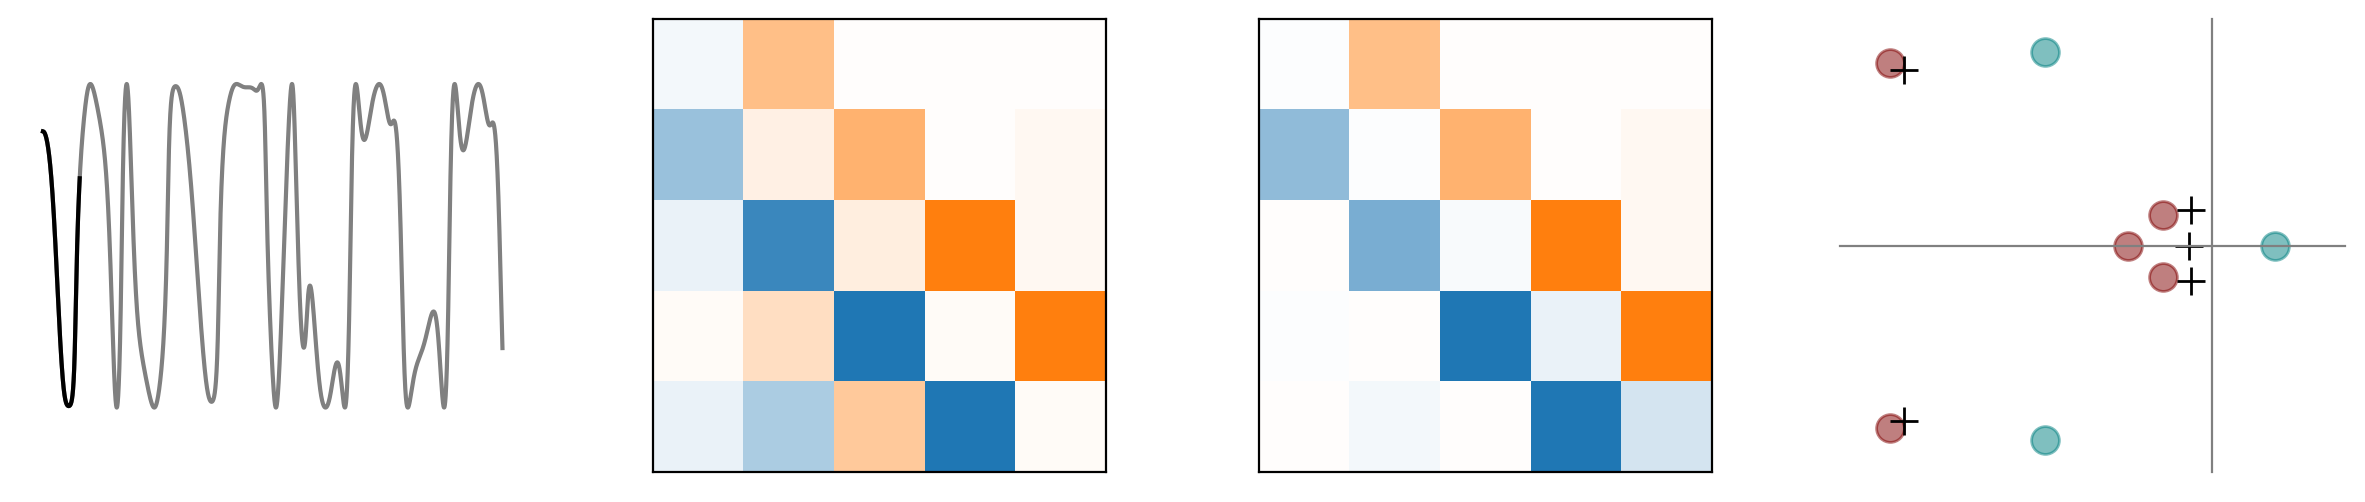

In [5]:
# Define parameters 
r = 5
rows = 101
dt = 0.001

short = dict()
longplot = dict()
full = dict()
short['n'] = 1200
longplot['n'] = 15000
full['n'] = int(10**5)

ωs_havok = []
ωs_shavok = []

for elem in (short, longplot, full):
    elem['xdata'] = get_pendulum_data(elem['n'])
    elem['H'] = build_hankel(elem['xdata'],rows,elem['xdata'].size-rows+1)
    elem['A1'] = HAVOK(elem['H'],dt,r,1)
    elem['A2'] = sHAVOK(elem['H'],dt,r,1)
    elem['ω1'] = np.linalg.eig(elem['A1'])[0]
    elem['ω2'] = np.linalg.eig(elem['A2'])[0]
    
# Plot results 
plt.figure(figsize=(15,3),dpi=200)

# Time series  
plt.subplot(1,4,1)
plt.plot(longplot['xdata'],color='gray')
plt.plot(short['xdata'],color='black')
plt.ylim(np.min(longplot['xdata']*1.4),np.max(longplot['xdata']*1.4))
plt.axis('off')
plt.xticks([])
plt.yticks([])

# HAVOK dynamics matrix 
plt.subplot(1,4,2)
plt.imshow(short['A1'],cmap=cmap,vmin=-10,vmax=10)
plt.xticks([])
plt.yticks([])
plt.grid('on',color='k')

# sHAVOK dynamics matrix 
plt.subplot(1,4,3)
plt.imshow(short['A2'],cmap=cmap,vmin=-10,vmax=10)
plt.xticks([])
plt.yticks([])

# Eigenvalues
ax = plt.subplot(1,4,4)
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.xticks([])
plt.yticks([])
plt.plot(short['ω1'].real,short['ω1'].imag,'o',color='teal',markersize=10,label='HAVOK',alpha=0.5)
plt.plot(short['ω2'].real,short['ω2'].imag,'o',color='maroon',markersize=10,label='sHAVOK',alpha=0.5)
plt.plot(full['ω1'].real,full['ω1'].imag,'+',color='k',markersize=10,label='true')
plt.xlim([-1.4,0.5])
plt.ylim([-50,50])
plt.savefig('pdf_files/fig8c.pdf')